In [1]:
%matplotlib inline

In [2]:
from pynq import Xlnk
from pynq import Overlay
from pynq import DefaultIP
from pynq import DefaultHierarchy
xlnk = Xlnk()

In [3]:
from skimage import measure
from skimage.io import imread
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
import cv2
import numpy as np
from PIL import Image
import time

In [4]:
class LabelAccelerate(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description=description)
        
    #bindto = ['xilinx.com:hls:hw_label_accel:1.0']
       
    def hw_label_f(self, image):
        (height, width) = image.shape
        self.label_accel.write(0x10, height)
        self.label_accel.write(0x18, width)
        with xlnk.cma_array(shape=(height, width), \
                            dtype=np.uint8, cacheable=1) as in_buffer,\
             xlnk.cma_array(shape=(height, width), \
                            dtype=np.uint16, cacheable=1) as out_buffer:
            
            in_buffer[0:height*width] = image
            self.label_dma.sendchannel.transfer(in_buffer)
            self.label_dma.recvchannel.transfer(out_buffer)
            self.label_accel.write(0x00,0x81) # start
            
            self.label_dma.sendchannel.wait()
            self.label_dma.recvchannel.wait()
            
        return out_buffer
    @staticmethod
    def checkhierarchy(description):
        if 'label_dma' in description['ip'] \
           and 'label_accel' in description['ip']:
            return True
        return False

In [75]:
image_path = "images/car0.jpg"

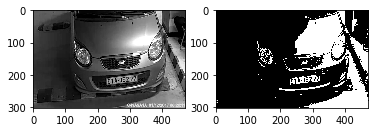

In [76]:
gray_car_image = cv2.imread(image_path, 0)
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = (gray_car_image > threshold_value) *255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

In [77]:
plate_dimensions = (0.05*binary_car_image.shape[0], 0.12*binary_car_image.shape[0], 0.15*binary_car_image.shape[1], 0.35*binary_car_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions

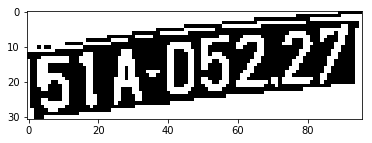

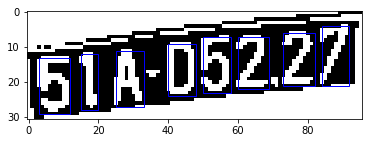

In [92]:
label_image_sw = measure.label(binary_car_image)
plate_objects_cordinates_sw = []
plate_like_objects_sw = []
for region in regionprops(label_image_sw):
        if region.area < 50:
            continue
        Min_row, Min_col, Max_row, Max_col = region.bbox
        region_height = Max_row - Min_row
        region_width = Max_col - Min_col
        ratio = float(region_width) / region_height
        if(3<ratio<5 
        and max_height >= region_height >= min_height 
        and max_width >= region_width >= min_width):
            plate_like_objects_sw.append(binary_car_image[Min_row:Max_row, Min_col:Max_col])
            plate_objects_cordinates_sw.append((Min_row, Min_col, Max_row, Max_col))

            
for i in range(len(plate_like_objects_sw)):
    plt.imshow(np.invert(plate_like_objects_sw[i]), cmap="gray")
    plt.show()

labelled_plate = np.invert(plate_like_objects_sw[0])
labelled_ch = measure.label(labelled_plate)
character_dimensions = (0.4*labelled_ch.shape[0], 0.8*labelled_ch.shape[0], 
                        0.01*labelled_ch.shape[1], 0.1*labelled_ch.shape[1])
minheight_ch, maxheight_ch, minwidth_ch, maxwidth_ch = character_dimensions
characters = []

fig, (ax) = plt.subplots(1, 1)
ax.imshow(labelled_plate, cmap="gray")
for region in regionprops(labelled_ch):
    y0, x0, y1, x1 = region.bbox
    regionheight_ch = y1 -y0
    regionwidth_ch = x1-x0
    ratio = float(regionheight_ch) / regionwidth_ch
    if(1.5<ratio<5.5 
        and maxheight_ch >= regionheight_ch >= minheight_ch 
        and maxwidth_ch >= regionwidth_ch >= minwidth_ch):
        rectBorder = patches.Rectangle((x0, y0), regionwidth_ch, regionheight_ch, 
                                           edgecolor="blue", linewidth=1, fill=False)
        ax.add_patch(rectBorder)
plt.show()

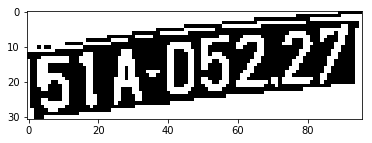

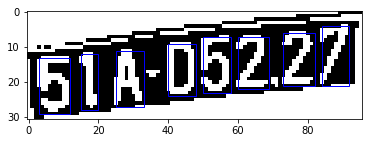

In [98]:
plate_objects_cordinates_hw = []
plate_like_objects_hw = []

design = Overlay("label.bit")
label_image_hw = design.hw_label_accel.hw_label_f(binary_car_image)
for region in regionprops(label_image_hw):
        if region.area < 50:
            continue
        Min_row, Min_col, Max_row, Max_col = region.bbox
        region_height = Max_row - Min_row
        region_width = Max_col - Min_col
        ratio = float(region_width) / region_height
        if(3<ratio<5 
        and max_height >= region_height >= min_height 
        and max_width >= region_width >= min_width):
            plate_like_objects_hw.append(binary_car_image[Min_row:Max_row, Min_col:Max_col])
            plate_objects_cordinates_hw.append((Min_row, Min_col, Max_row, Max_col))
            
for i in range(len(plate_like_objects_hw)):
    plt.imshow(np.invert(plate_like_objects_hw[i]), cmap="gray")
    plt.show()
    
labelled_plate = np.invert(plate_like_objects_hw[0])
labelled_ch = measure.label(labelled_plate)
character_dimensions = (0.4*labelled_ch.shape[0], 0.8*labelled_ch.shape[0], 
                        0.01*labelled_ch.shape[1], 0.1*labelled_ch.shape[1])
minheight_ch, maxheight_ch, minwidth_ch, maxwidth_ch = character_dimensions
characters = []

fig, (ax) = plt.subplots(1, 1)
ax.imshow(labelled_plate, cmap="gray")
for region in regionprops(labelled_ch):
    y0, x0, y1, x1 = region.bbox
    regionheight_ch = y1 -y0
    regionwidth_ch = x1-x0
    ratio = float(regionheight_ch) / regionwidth_ch
    if(1.5<ratio<5.5 
        and maxheight_ch >= regionheight_ch >= minheight_ch 
        and maxwidth_ch >= regionwidth_ch >= minwidth_ch):
        rectBorder = patches.Rectangle((x0, y0), regionwidth_ch, regionheight_ch, 
                                           edgecolor="blue", linewidth=1, fill=False)
        ax.add_patch(rectBorder)
plt.show()

In [ ]:
xlnk.xlnk_reset()